In [1]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Dec 14 08:06:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

#Данные

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!unzip -q /content/gdrive/My\ Drive/train.zip -d train
!unzip -q /content/gdrive/My\ Drive/test.zip -d test

In [4]:
import pickle
import numpy as np
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from matplotlib import colors, pyplot as plt
%matplotlib inline

In [5]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [6]:
class DogsDataset(Dataset):
  def __init__(self, files, mode):
    super().__init__()
    # список файлов для загрузки
    self.files = sorted(files)
    # режим работы
    self.mode = mode
    if self.mode not in DATA_MODES:
      print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
      raise NameError
    self.len_ = len(self.files)

    self.label_encoder = LabelEncoder()
    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)
      with open('label_encoder.pkl', 'wb') as le_dump_file:
        pickle.dump(self.label_encoder, le_dump_file)

  def __len__(self):
      return self.len_

  def load_sample(self, file):
      image = Image.open(file)
      image.load()
      return image
  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)
  def __getitem__(self, index):
    transform_train = transforms.Compose([
          transforms.ToTensor(),
          transforms.ToPILImage(),
          transforms.RandomChoice([
                                   transforms.ColorJitter(),
          transforms.RandomGrayscale(p=0.1),
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.RandomRotation(20),
          ]),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 
    transform_test = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)
    x = np.array(x / 255, dtype='float32')
    if self.mode == 'test':
        return transform_test(x) #тестовую не меняем
    else:
        if self.mode == 'train':
          x= transform_train(x)
        else:
          x=transform_test(x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y


In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
 inp = inp.numpy().transpose((1, 2, 0))
 mean = np.array([0.485, 0.456, 0.406])
 std = np.array([0.229, 0.224, 0.225])
 inp = std * inp + mean
 inp = np.clip(inp, 0, 1)
 plt_ax.imshow(inp)
 if title is not None:
   plt_ax.set_title(title)
 plt_ax.grid(False)

In [42]:
TRAIN_DIR = Path('train')
TEST_DIR = Path('test')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpeg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpeg')))

In [43]:
from sklearn.model_selection import train_test_split
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
 stratify=train_val_labels)

In [44]:
val_dataset = DogsDataset(val_files, mode='val')

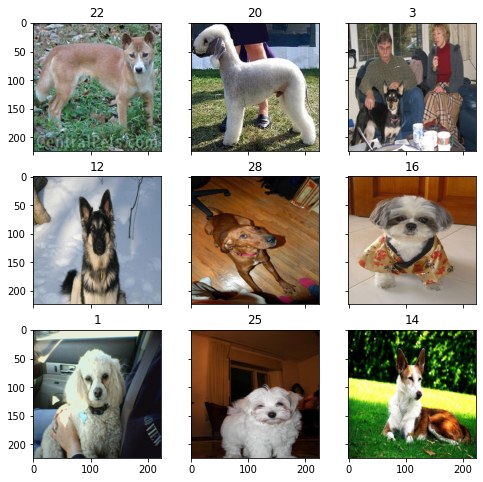

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
 random_characters = int(np.random.uniform(0,1000))
 im_val, label = val_dataset[random_characters]
 img_label = " ".join(map(lambda x: x.capitalize(),\
 val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
 imshow(im_val.data.cpu(), \
 title=img_label,plt_ax=fig_x)

In [12]:
import torchvision
from torchvision import transforms, models

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer):
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0
  for inputs, labels in train_loader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  train_loss = running_loss / processed_data
  train_acc = running_corrects.cpu().numpy() / processed_data
  return train_loss, train_acc


In [14]:
def eval_epoch(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  processed_size = 0
  for inputs, labels in val_loader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_size += inputs.size(0)
  val_loss = running_loss / processed_size
  val_acc = running_corrects.double() / processed_size
  return val_loss, val_acc

In [15]:
def train(train_files, val_files, model, opt, epochs, batch_size, name):
  train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)
  history = []
  final_acc = 0
  log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
  val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
  with tqdm(desc="epoch", total=epochs) as pbar_outer:
    #opt = torch.optim.AdamW(model.parameters(), lr=0.00005, amsgrad=True)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
      train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
      print("loss", train_loss)
      val_loss, val_acc = eval_epoch(model, val_loader, criterion)
      if val_acc > final_acc:
        torch.save({'model_state_dict': model.state_dict(),}, name)
        final_acc = val_acc
        print("Saved model with val acc", val_acc.item())
      history.append((train_loss, train_acc.item(), val_loss, val_acc.item()))
      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

  return history

In [16]:
def predict(model, test_loader):
  with torch.no_grad():
    logits = []

    for inputs in test_loader:
      inputs = inputs.to(DEVICE)
      model.eval()
      outputs = model(inputs).cpu()
      logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [17]:
if val_dataset is None:
 val_dataset = DogsDataset(val_files, mode='val')

train_dataset = DogsDataset(train_files, mode='train')

In [45]:
idxs = list(range(len(val_dataset)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

#VGG фиксированный lr

In [20]:
import torchvision
from torchvision import transforms, models

In [ ]:
# Создаём сеть
model_vgg = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
torch.cuda.empty_cache()
name = '/content/gdrive/MyDrive/DogsModelVGG19.pth'
opt = torch.optim.AdamW(model_vgg.parameters(), lr=0.00005, amsgrad=True)
history = train(train_dataset, val_dataset, model= model_vgg.cuda(), opt = opt, epochs=10, batch_size=32, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 4.249772109193876


epoch:  10%|█         | 1/10 [03:02<27:22, 182.49s/it]

Saved model with val acc 0.36662946428571425

Epoch 001 train_loss: 4.2498   val_loss 2.3610 train_acc 0.0869 val_acc 0.3666
loss 1.4187007128282865


epoch:  20%|██        | 2/10 [06:03<24:15, 181.93s/it]

Saved model with val acc 0.7282366071428571

Epoch 002 train_loss: 1.4187   val_loss 0.9030 train_acc 0.5955 val_acc 0.7282
loss 0.6412740914316749


epoch:  30%|███       | 3/10 [09:05<21:13, 181.96s/it]

Saved model with val acc 0.7399553571428571

Epoch 003 train_loss: 0.6413   val_loss 0.8595 train_acc 0.8005 val_acc 0.7400
loss 0.35807253654933924


epoch:  40%|████      | 4/10 [12:09<18:15, 182.63s/it]

Saved model with val acc 0.7829241071428571

Epoch 004 train_loss: 0.3581   val_loss 0.7850 train_acc 0.8859 val_acc 0.7829
loss 0.22322755393194008


epoch:  50%|█████     | 5/10 [15:13<15:15, 183.18s/it]


Epoch 005 train_loss: 0.2232   val_loss 0.9213 train_acc 0.9287 val_acc 0.7628
loss 0.170963523887267


epoch:  60%|██████    | 6/10 [18:21<12:17, 184.41s/it]

Saved model with val acc 0.7912946428571428

Epoch 006 train_loss: 0.1710   val_loss 0.8509 train_acc 0.9447 val_acc 0.7913
loss 0.13551153837913557


epoch:  70%|███████   | 7/10 [21:29<09:16, 185.59s/it]

Saved model with val acc 0.7940848214285714

Epoch 007 train_loss: 0.1355   val_loss 0.8235 train_acc 0.9604 val_acc 0.7941
loss 0.12589721402460463


epoch:  80%|████████  | 8/10 [24:38<06:13, 186.63s/it]

Saved model with val acc 0.8018973214285714

Epoch 008 train_loss: 0.1259   val_loss 0.8795 train_acc 0.9594 val_acc 0.8019
loss 0.1441309917614191


epoch:  90%|█████████ | 9/10 [27:38<03:04, 184.51s/it]


Epoch 009 train_loss: 0.1441   val_loss 1.0448 train_acc 0.9598 val_acc 0.7606
loss 0.1122803503517817


epoch: 100%|██████████| 10/10 [30:32<00:00, 183.21s/it]


Epoch 010 train_loss: 0.1123   val_loss 0.8520 train_acc 0.9645 val_acc 0.7902


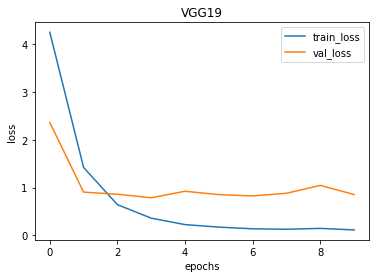

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VGG19")
plt.show()


In [ ]:
checkpoint = torch.load(name)
model_vgg.load_state_dict(checkpoint['model_state_dict'])

model_vgg.eval()
probs_ims = predict(model_vgg, imgs)
actual_labels = [val_dataset[id][1] for id in idxs]
f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro')

0.7970725216234198

#ResNet фиксированный lr

In [ ]:
model_resnet = models.resnet152(pretrained=True)
model_resnet.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=1000, bias=True),
 nn.Dropout(0.5),
 nn.Linear(1000, 50, bias=True))

In [ ]:
torch.cuda.empty_cache()
name = '/content/gdrive/MyDrive/DogsModelRESNET152.pth'
opt = torch.optim.AdamW(model_resnet.parameters(), lr=0.00005, amsgrad=True)
history = train(train_dataset, val_dataset, model=model_resnet.cuda(), opt = opt, epochs=10, batch_size=64, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.3248002827722076


epoch:  10%|█         | 1/10 [03:11<28:45, 191.68s/it]

Saved model with val acc 0.859375

Epoch 001 train_loss: 2.3248   val_loss 0.8717 train_acc 0.5458 val_acc 0.8594
loss 0.5092782299559401


epoch:  20%|██        | 2/10 [06:17<25:19, 189.88s/it]


Epoch 002 train_loss: 0.5093   val_loss 0.5060 train_acc 0.8465 val_acc 0.8443
loss 0.2612076627196634


epoch:  30%|███       | 3/10 [09:23<22:01, 188.82s/it]

Saved model with val acc 0.8850446428571428

Epoch 003 train_loss: 0.2612   val_loss 0.3852 train_acc 0.9181 val_acc 0.8850
loss 0.19058709402797744


epoch:  40%|████      | 4/10 [12:29<18:46, 187.78s/it]


Epoch 004 train_loss: 0.1906   val_loss 0.5099 train_acc 0.9395 val_acc 0.8471
loss 0.15876514915200826


epoch:  50%|█████     | 5/10 [15:34<15:35, 187.08s/it]


Epoch 005 train_loss: 0.1588   val_loss 0.4549 train_acc 0.9477 val_acc 0.8750
loss 0.1441731144714675


epoch:  60%|██████    | 6/10 [18:39<12:25, 186.45s/it]


Epoch 006 train_loss: 0.1442   val_loss 0.4190 train_acc 0.9544 val_acc 0.8789
loss 0.0971233955170969


epoch:  70%|███████   | 7/10 [21:44<09:18, 186.08s/it]


Epoch 007 train_loss: 0.0971   val_loss 0.5083 train_acc 0.9676 val_acc 0.8577
loss 0.11500081966191275


epoch:  80%|████████  | 8/10 [24:50<06:11, 185.88s/it]


Epoch 008 train_loss: 0.1150   val_loss 0.6228 train_acc 0.9633 val_acc 0.8387
loss 0.08875037791019574


epoch:  90%|█████████ | 9/10 [27:55<03:05, 185.80s/it]


Epoch 009 train_loss: 0.0888   val_loss 0.5450 train_acc 0.9726 val_acc 0.8705
loss 0.09229233046868143


epoch: 100%|██████████| 10/10 [31:00<00:00, 186.07s/it]


Epoch 010 train_loss: 0.0923   val_loss 0.5213 train_acc 0.9723 val_acc 0.8644


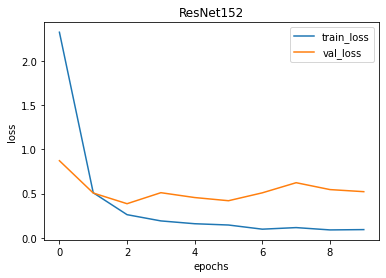

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("ResNet152")
plt.show()

In [ ]:
checkpoint = torch.load(name)
model_resnet.load_state_dict(checkpoint['model_state_dict'])

model_resnet.eval()
probs_ims = predict(model_resnet, imgs)
actual_labels = [val_dataset[id][1] for id in idxs]
from sklearn.metrics import f1_score
f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro')

0.8915502328675982

#DenseNet фиксированный lr

In [ ]:
# Вернем первоначальные веса resnet50
model_densenet = models.densenet161(pretrained=True)

#Заменяем родной классификатор model на наш новый линейный классификатор
model_densenet.classifier = nn.Sequential(nn.Linear(2208, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(128, 50))

In [ ]:
torch.cuda.empty_cache()
name = '/content/gdrive/MyDrive/DogsModelDENSENET161.pth'
opt = torch.optim.AdamW(model_densenet.parameters(), lr=0.00005, amsgrad=True)
history = train(train_dataset, val_dataset, model=model_densenet.cuda(), opt = opt, epochs=10, batch_size=32, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.956802049178282


epoch:  10%|█         | 1/10 [03:12<28:50, 192.30s/it]

Saved model with val acc 0.8364955357142857

Epoch 001 train_loss: 2.9568   val_loss 1.9886 train_acc 0.3969 val_acc 0.8365
loss 0.7358540213813469


epoch:  20%|██        | 2/10 [06:20<25:29, 191.14s/it]


Epoch 002 train_loss: 0.7359   val_loss 0.5863 train_acc 0.7920 val_acc 0.8309
loss 0.3294027926290084


epoch:  30%|███       | 3/10 [09:28<22:11, 190.15s/it]


Epoch 003 train_loss: 0.3294   val_loss 0.6341 train_acc 0.8980 val_acc 0.8170
loss 0.224619402854825


epoch:  40%|████      | 4/10 [12:36<18:57, 189.58s/it]

Saved model with val acc 0.8683035714285714

Epoch 004 train_loss: 0.2246   val_loss 0.4541 train_acc 0.9276 val_acc 0.8683
loss 0.14314911872492345


epoch:  50%|█████     | 5/10 [15:44<15:45, 189.03s/it]


Epoch 005 train_loss: 0.1431   val_loss 0.5134 train_acc 0.9529 val_acc 0.8638
loss 0.1381971099794155


epoch:  60%|██████    | 6/10 [18:52<12:35, 188.79s/it]

Saved model with val acc 0.8705357142857142

Epoch 006 train_loss: 0.1382   val_loss 0.4945 train_acc 0.9576 val_acc 0.8705
loss 0.11799254514911958


epoch:  70%|███████   | 7/10 [22:01<09:26, 188.68s/it]

Saved model with val acc 0.875

Epoch 007 train_loss: 0.1180   val_loss 0.4729 train_acc 0.9626 val_acc 0.8750
loss 0.08563707006944792


epoch:  80%|████████  | 8/10 [25:08<06:16, 188.24s/it]


Epoch 008 train_loss: 0.0856   val_loss 0.4693 train_acc 0.9717 val_acc 0.8711
loss 0.07691360364699612


epoch:  90%|█████████ | 9/10 [28:15<03:07, 187.96s/it]


Epoch 009 train_loss: 0.0769   val_loss 0.6164 train_acc 0.9743 val_acc 0.8477
loss 0.07767385736545933


epoch: 100%|██████████| 10/10 [31:23<00:00, 188.32s/it]


Epoch 010 train_loss: 0.0777   val_loss 0.6000 train_acc 0.9764 val_acc 0.8549


In [ ]:
checkpoint = torch.load(name)
model_densenet.load_state_dict(checkpoint['model_state_dict'])

model_densenet.eval()
probs_ims = predict(model_densenet, imgs)
actual_labels = [val_dataset[id][1] for id in idxs]
from sklearn.metrics import f1_score
f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro')

0.8762475049900199

#EfficientNet фиксированный lr

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

model_effnet_b6 = EfficientNet.from_pretrained('efficientnet-b6', num_classes=50)

Loaded pretrained weights for efficientnet-b6


In [ ]:
torch.cuda.empty_cache()
name = '/content/gdrive/MyDrive/DogsModelEFFNET_B6.pth'
opt = torch.optim.AdamW(model_effnet_b6.parameters(), lr=0.00005, amsgrad=True)
history = train(train_dataset, val_dataset, model= model_effnet_b6.cuda(), opt = opt, epochs=10, batch_size=32, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.629543036477558


epoch:  10%|█         | 1/10 [04:22<39:23, 262.56s/it]

Saved model with val acc 0.7672991071428571

Epoch 001 train_loss: 3.6295   val_loss 2.8469 train_acc 0.2304 val_acc 0.7673
loss 0.6694134114220722


epoch:  20%|██        | 2/10 [08:39<34:48, 261.02s/it]

Saved model with val acc 0.9068080357142857

Epoch 002 train_loss: 0.6694   val_loss 0.3046 train_acc 0.8537 val_acc 0.9068
loss 0.13540426756220322


epoch:  30%|███       | 3/10 [12:57<30:19, 259.90s/it]


Epoch 003 train_loss: 0.1354   val_loss 0.3044 train_acc 0.9600 val_acc 0.9051
loss 0.05794454795202004


epoch:  40%|████      | 4/10 [17:15<25:55, 259.25s/it]

Saved model with val acc 0.9268973214285714

Epoch 004 train_loss: 0.0579   val_loss 0.2786 train_acc 0.9823 val_acc 0.9269
loss 0.03721579169396312


epoch:  50%|█████     | 5/10 [21:31<21:32, 258.54s/it]


Epoch 005 train_loss: 0.0372   val_loss 0.3893 train_acc 0.9888 val_acc 0.9062
loss 0.0385341805828424


epoch:  60%|██████    | 6/10 [25:48<17:11, 257.93s/it]


Epoch 006 train_loss: 0.0385   val_loss 0.3441 train_acc 0.9894 val_acc 0.9113
loss 0.02906425770858783


epoch:  70%|███████   | 7/10 [30:05<12:52, 257.61s/it]


Epoch 007 train_loss: 0.0291   val_loss 0.3212 train_acc 0.9920 val_acc 0.9129
loss 0.026549174553712265


epoch:  80%|████████  | 8/10 [34:22<08:34, 257.37s/it]


Epoch 008 train_loss: 0.0265   val_loss 0.3096 train_acc 0.9929 val_acc 0.9230
loss 0.02546955427105681


epoch:  90%|█████████ | 9/10 [38:39<04:17, 257.45s/it]

Saved model with val acc 0.9291294642857142

Epoch 009 train_loss: 0.0255   val_loss 0.3002 train_acc 0.9937 val_acc 0.9291
loss 0.01883186717910375


epoch: 100%|██████████| 10/10 [42:57<00:00, 257.72s/it]


Epoch 010 train_loss: 0.0188   val_loss 0.3197 train_acc 0.9952 val_acc 0.9224


In [ ]:
checkpoint = torch.load(name)
model_effnet_b6.load_state_dict(checkpoint['model_state_dict'])

model_effnet_b6.eval()
probs_ims = predict(model_effnet_b6, imgs)
actual_labels = [val_dataset[id][1] for id in idxs]
from sklearn.metrics import f1_score
f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro')

0.9354624085163007

#VGG дифференцированное обучение слоев

In [ ]:
found_lr =0.00005

In [ ]:
model_vgg = models.vgg19(pretrained=True)

In [ ]:
model_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=50, bias=True)

In [ ]:
param512 = model_vgg.features[27:36].parameters()
param256 = model_vgg.features[18:27].parameters()
param128 = model_vgg.features[9:18].parameters()
param64 = model_vgg.features[0:9].parameters()

In [ ]:
opt = torch.optim.Adam([
{ 'params': model_vgg.classifier.parameters(), 'lr': found_lr},
{ 'params': param512, 'lr': found_lr / 3},
{ 'params': param256, 'lr': found_lr / 10},
{ 'params': param128, 'lr': found_lr / 50},
{ 'params': param64, 'lr': found_lr / 100},
], lr=found_lr / 100)

In [ ]:
name = '/content/gdrive/MyDrive/DogsModelVGG_with_LR.pth'
history = train(train_dataset, val_dataset, model = model_vgg.cuda(), opt = opt, epochs = 10, batch_size = 64, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.5474957935110005


epoch:  10%|█         | 1/10 [02:08<19:17, 128.65s/it]

Saved model with val acc 0.8761160714285714

Epoch 001 train_loss: 1.5475   val_loss 0.4276 train_acc 0.5880 val_acc 0.8761
loss 0.3051811480970244


epoch:  20%|██        | 2/10 [04:07<16:45, 125.71s/it]

Saved model with val acc 0.8816964285714285

Epoch 002 train_loss: 0.3052   val_loss 0.3731 train_acc 0.9062 val_acc 0.8817
loss 0.1564621245790069


epoch:  30%|███       | 3/10 [06:05<14:23, 123.40s/it]

Saved model with val acc 0.8883928571428571

Epoch 003 train_loss: 0.1565   val_loss 0.4032 train_acc 0.9550 val_acc 0.8884
loss 0.0876908046985409


epoch:  40%|████      | 4/10 [07:57<11:59, 119.94s/it]


Epoch 004 train_loss: 0.0877   val_loss 0.4156 train_acc 0.9715 val_acc 0.8817
loss 0.06656445613304922


epoch:  50%|█████     | 5/10 [09:50<09:48, 117.77s/it]


Epoch 005 train_loss: 0.0666   val_loss 0.4383 train_acc 0.9808 val_acc 0.8845
loss 0.06662051002853725


epoch:  60%|██████    | 6/10 [11:45<07:48, 117.06s/it]


Epoch 006 train_loss: 0.0666   val_loss 0.4542 train_acc 0.9801 val_acc 0.8772
loss 0.056578928528122734


epoch:  70%|███████   | 7/10 [13:41<05:50, 116.81s/it]


Epoch 007 train_loss: 0.0566   val_loss 0.5085 train_acc 0.9829 val_acc 0.8806
loss 0.04805992906417519


epoch:  80%|████████  | 8/10 [15:37<03:53, 116.58s/it]


Epoch 008 train_loss: 0.0481   val_loss 0.4814 train_acc 0.9855 val_acc 0.8778
loss 0.04107831553464175


epoch:  90%|█████████ | 9/10 [17:36<01:57, 117.13s/it]


Epoch 009 train_loss: 0.0411   val_loss 0.4665 train_acc 0.9879 val_acc 0.8817
loss 0.0320695396200804


epoch: 100%|██████████| 10/10 [19:35<00:00, 117.59s/it]


Epoch 010 train_loss: 0.0321   val_loss 0.5524 train_acc 0.9913 val_acc 0.8677


In [ ]:
from sklearn.metrics import f1_score

In [ ]:
checkpoint = torch.load(name)
model_vgg.load_state_dict(checkpoint['model_state_dict'])

model_vgg.eval()
probs_ims = predict(model_vgg, imgs)
actual_labels = [val_dataset[id][1] for id in idxs]
f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro')

0.8915502328675982

#ResNet дифференцированное обучение слоев

In [ ]:
found_lr =0.00005

In [ ]:
model_resnet = models.resnet152(pretrained=True)
model_resnet = model_resnet.cuda()
model_resnet.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=1000, bias=True),
 nn.Dropout(0.5),
 nn.Linear(1000, 50, bias=True))

In [ ]:
opt = torch.optim.AdamW([{ 'params': model_resnet.fc.parameters(), 'lr': found_lr},
                         { 'params': model_resnet.layer4.parameters(), 'lr': found_lr / 3},
                         { 'params': model_resnet.layer3.parameters(), 'lr': found_lr / 10},
                         { 'params': model_resnet.layer2.parameters(), 'lr': found_lr / 50},
                         { 'params': model_resnet.layer1.parameters(), 'lr': found_lr / 100},
                         {'params': model_resnet.bn1.parameters(), 'lr': found_lr / 1000},
                         {'params': model_resnet.conv1.parameters(), 'lr': found_lr / 1000}],
                        lr=found_lr / 100, amsgrad=True)

In [ ]:
name = '/content/gdrive/MyDrive/DogsModelRESNET152_with_LR.pth'
torch.cuda.empty_cache()
history = train(train_dataset, val_dataset, model = model_resnet.cuda(), opt = opt, epochs = 10, batch_size = 64, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.871777070158691


epoch:  10%|█         | 1/10 [02:08<19:15, 128.37s/it]

Saved model with val acc 0.84765625

Epoch 001 train_loss: 2.8718   val_loss 1.4171 train_acc 0.4669 val_acc 0.8477
loss 0.3923077037232846


epoch:  20%|██        | 2/10 [04:15<17:04, 128.03s/it]

Saved model with val acc 0.91796875

Epoch 002 train_loss: 0.3923   val_loss 0.2645 train_acc 0.8885 val_acc 0.9180
loss 0.18079224540247188


epoch:  30%|███       | 3/10 [06:22<14:54, 127.76s/it]


Epoch 003 train_loss: 0.1808   val_loss 0.2859 train_acc 0.9440 val_acc 0.9113
loss 0.12097307146261028


epoch:  40%|████      | 4/10 [08:29<12:44, 127.40s/it]


Epoch 004 train_loss: 0.1210   val_loss 0.2824 train_acc 0.9630 val_acc 0.9169
loss 0.08724586129088716


epoch:  50%|█████     | 5/10 [10:35<10:35, 127.15s/it]


Epoch 005 train_loss: 0.0872   val_loss 0.3006 train_acc 0.9719 val_acc 0.9062
loss 0.07141175950836816


epoch:  60%|██████    | 6/10 [12:44<08:30, 127.54s/it]

Saved model with val acc 0.9263392857142857

Epoch 006 train_loss: 0.0714   val_loss 0.2954 train_acc 0.9769 val_acc 0.9263
loss 0.06113124226476785


epoch:  70%|███████   | 7/10 [14:51<06:22, 127.55s/it]


Epoch 007 train_loss: 0.0611   val_loss 0.3128 train_acc 0.9814 val_acc 0.9129
loss 0.049355753597979835


epoch:  80%|████████  | 8/10 [17:00<04:15, 127.79s/it]

Saved model with val acc 0.9268973214285714

Epoch 008 train_loss: 0.0494   val_loss 0.2714 train_acc 0.9855 val_acc 0.9269
loss 0.03636820721646246


epoch:  90%|█████████ | 9/10 [19:07<02:07, 127.70s/it]


Epoch 009 train_loss: 0.0364   val_loss 0.3162 train_acc 0.9881 val_acc 0.9252
loss 0.027779551596385278


epoch: 100%|██████████| 10/10 [21:15<00:00, 127.51s/it]


Epoch 010 train_loss: 0.0278   val_loss 0.2954 train_acc 0.9926 val_acc 0.9241


In [ ]:
checkpoint = torch.load(name)
model_resnet.load_state_dict(checkpoint['model_state_dict'])

model_resnet.eval()
probs_ims = predict(model_resnet, imgs)
actual_labels = [val_dataset[id][1] for id in idxs]
f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro')

0.927478376580173

#DenseNet дифференцированное обучение слоев

In [ ]:
# Вернем первоначальные веса resnet50
model_densenet = models.densenet161(pretrained=True)
found_lr =0.00005
#Заменяем родной классификатор model на наш новый линейный классификатор
model_densenet.classifier = nn.Sequential(nn.Linear(2208, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(128, 50))

In [ ]:
param01 = model_densenet.features.conv0.parameters()
param02 = model_densenet.features.norm0.parameters()
param1 = model_densenet.features.denseblock1.parameters()
param2 = model_densenet.features.denseblock2.parameters()
param3 = model_densenet.features.denseblock3.parameters()
param4 = model_densenet.features.denseblock4.parameters()
param41 = model_densenet.features.norm5.parameters()

In [ ]:
opt = torch.optim.AdamW([{ 'params': model_densenet.classifier.parameters(), 'lr': found_lr},
                         { 'params': param41, 'lr': found_lr / 3},
                         { 'params': param4, 'lr': found_lr / 10},
                         { 'params': param3, 'lr': found_lr / 50},
                         { 'params': param2, 'lr': found_lr / 100},
                         {'params': param1, 'lr': found_lr / 1000},
                         {'params': param02, 'lr': found_lr / 1000},
                         {'params': param01, 'lr': found_lr / 1000}],
                        lr=found_lr / 100, amsgrad=True)

In [ ]:
print('Params to update:')
i = 0
for name,param in model_densenet.named_parameters():
  print(f"{i} {name}")
  i += 1

In [ ]:
name = '/content/gdrive/MyDrive/DogsModelDENSENET161_with_LR.pth'
torch.cuda.empty_cache()
history = train(train_dataset, val_dataset, model = model_densenet.cuda(), opt = opt, epochs = 10, batch_size = 32, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.510464099423345


epoch:  10%|█         | 1/10 [02:19<20:55, 139.46s/it]

Saved model with val acc 0.5803571428571428

Epoch 001 train_loss: 3.5105   val_loss 2.8576 train_acc 0.1649 val_acc 0.5804
loss 0.9006841207331425


epoch:  20%|██        | 2/10 [04:38<18:33, 139.20s/it]

Saved model with val acc 0.8733258928571428

Epoch 002 train_loss: 0.9007   val_loss 0.4271 train_acc 0.7862 val_acc 0.8733
loss 0.33075373254059237


epoch:  30%|███       | 3/10 [06:56<16:12, 138.97s/it]

Saved model with val acc 0.9017857142857142

Epoch 003 train_loss: 0.3308   val_loss 0.3394 train_acc 0.9036 val_acc 0.9018
loss 0.2432292899568151


epoch:  40%|████      | 4/10 [09:15<13:53, 138.85s/it]

Saved model with val acc 0.9112723214285714

Epoch 004 train_loss: 0.2432   val_loss 0.3036 train_acc 0.9272 val_acc 0.9113
loss 0.18533508591617312


epoch:  50%|█████     | 5/10 [11:33<11:33, 138.62s/it]


Epoch 005 train_loss: 0.1853   val_loss 0.3249 train_acc 0.9473 val_acc 0.8990
loss 0.13795853368896377


epoch:  60%|██████    | 6/10 [13:51<09:13, 138.48s/it]


Epoch 006 train_loss: 0.1380   val_loss 0.3038 train_acc 0.9604 val_acc 0.9062
loss 0.12108012050623161


epoch:  70%|███████   | 7/10 [16:09<06:55, 138.34s/it]


Epoch 007 train_loss: 0.1211   val_loss 0.3001 train_acc 0.9656 val_acc 0.9090
loss 0.10463773391955086


epoch:  80%|████████  | 8/10 [18:27<04:36, 138.32s/it]

Saved model with val acc 0.9135044642857142

Epoch 008 train_loss: 0.1046   val_loss 0.2803 train_acc 0.9717 val_acc 0.9135
loss 0.07989572429184492


epoch:  90%|█████████ | 9/10 [20:45<02:18, 138.28s/it]


Epoch 009 train_loss: 0.0799   val_loss 0.3186 train_acc 0.9792 val_acc 0.9068
loss 0.06558739152991022


epoch: 100%|██████████| 10/10 [23:03<00:00, 138.37s/it]


Epoch 010 train_loss: 0.0656   val_loss 0.3090 train_acc 0.9838 val_acc 0.9124


In [ ]:
checkpoint = torch.load(name)
model_densenet.load_state_dict(checkpoint['model_state_dict'])

model_densenet.eval()
probs_ims = predict(model_densenet, imgs)
actual_labels = [val_dataset[id][1] for id in idxs]
f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro')

0.9128409846972722

#EfficientNet дифференцированное обучение слоев

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

model_effnet_b6 = EfficientNet.from_pretrained('efficientnet-b6', num_classes=50)

Loaded pretrained weights for efficientnet-b6


In [ ]:
found_lr = 0.00005
opt = torch.optim.Adam([
{ 'params': model_effnet_b6._conv_stem.parameters(), 'lr': found_lr / 100},
{ 'params': model_effnet_b6._bn0.parameters(), 'lr': found_lr / 100},
{ 'params': model_effnet_b6._blocks[:11].parameters(), 'lr': found_lr / 50},
{ 'params': model_effnet_b6._blocks[11:22].parameters(), 'lr': found_lr / 50},
{ 'params': model_effnet_b6._blocks[22:33].parameters(), 'lr': found_lr / 3},
{ 'params': model_effnet_b6._blocks[33:44].parameters(), 'lr': found_lr / 3},
{ 'params': model_effnet_b6._bn1.parameters(), 'lr': found_lr},
{ 'params': model_effnet_b6._fc.parameters(), 'lr': found_lr},
], lr=found_lr / 100, amsgrad=True)

In [ ]:
i = 0
for name,param in model_effnet_b6.named_parameters():
  print(f"{i} {name}")
  i += 1

In [ ]:
name = '/content/gdrive/MyDrive/DogsModelEFFNET_B6_with_LR.pth'
torch.cuda.empty_cache()
history = train(train_dataset, val_dataset, model = model_effnet_b6.cuda(), opt = opt, epochs = 10, batch_size = 32, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.833459596009249


epoch:  10%|█         | 1/10 [04:28<40:12, 268.09s/it]

Saved model with val acc 0.47935267857142855

Epoch 001 train_loss: 3.8335   val_loss 3.6801 train_acc 0.0832 val_acc 0.4794
loss 2.808733936730574


epoch:  20%|██        | 2/10 [08:51<35:33, 266.65s/it]

Saved model with val acc 0.80859375

Epoch 002 train_loss: 2.8087   val_loss 0.7059 train_acc 0.6744 val_acc 0.8086
loss 0.4384771704917776


epoch:  30%|███       | 3/10 [13:14<30:59, 265.67s/it]

Saved model with val acc 0.8962053571428571

Epoch 003 train_loss: 0.4385   val_loss 0.3768 train_acc 0.8735 val_acc 0.8962
loss 0.20174682397668495


epoch:  40%|████      | 4/10 [17:37<26:28, 264.68s/it]


Epoch 004 train_loss: 0.2017   val_loss 0.3476 train_acc 0.9418 val_acc 0.8951
loss 0.1190582228208236


epoch:  50%|█████     | 5/10 [21:59<22:00, 264.09s/it]

Saved model with val acc 0.9029017857142857

Epoch 005 train_loss: 0.1191   val_loss 0.3328 train_acc 0.9656 val_acc 0.9029
loss 0.07684536936516473


epoch:  60%|██████    | 6/10 [26:22<17:34, 263.56s/it]


Epoch 006 train_loss: 0.0768   val_loss 0.3595 train_acc 0.9816 val_acc 0.9018
loss 0.05499629489314969


epoch:  70%|███████   | 7/10 [30:44<13:09, 263.33s/it]

Saved model with val acc 0.9056919642857142

Epoch 007 train_loss: 0.0550   val_loss 0.3611 train_acc 0.9849 val_acc 0.9057
loss 0.04314401981954237


epoch:  80%|████████  | 8/10 [35:07<08:45, 262.97s/it]


Epoch 008 train_loss: 0.0431   val_loss 0.3717 train_acc 0.9898 val_acc 0.9023
loss 0.030898500915310354


epoch:  90%|█████████ | 9/10 [39:29<04:22, 262.88s/it]


Epoch 009 train_loss: 0.0309   val_loss 0.3756 train_acc 0.9924 val_acc 0.9012
loss 0.026154743011515404


epoch: 100%|██████████| 10/10 [43:53<00:00, 263.34s/it]


Epoch 010 train_loss: 0.0262   val_loss 0.4234 train_acc 0.9920 val_acc 0.8895


In [ ]:
checkpoint = torch.load(name)
model_effnet_b6.load_state_dict(checkpoint['model_state_dict'])

model_effnet_b6.eval()
probs_ims = predict(model_effnet_b6, imgs)
actual_labels = [val_dataset[id][1] for id in idxs]
from sklearn.metrics import f1_score
f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro')

0.9095143047238856

#Ансамбль VGG+ResNet+DenseNet

In [21]:
class MyEnsemble(nn.Module):
    """Модель-ансамбль из 4 моделей: modelA, modelB, modelC и modelD
    технически является нейросетью нейросетей, выходы от нейросетей modelA, 
    modelB, modelC и modelD являются входными признаками на одиночный 
    линейный слой. В качестве выходных так же наши классы.
    Мы надеемся что линейный слой перестроится, таким образом, чтобы собирать 
    более точные предсказания от более точной сети для каждого из классов.
    https://discuss.pytorch.org/t/combining-trained-models-in-pytorch/28383"""
    
    def __init__(self, modelA, modelB, modelC):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier =  nn.Sequential(nn.Linear(50 * 3, 128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(),
                    nn.Dropout(p=0.3),
                    nn.Linear(128, 50)) # посмотреть с dropout и ReLu
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.classifier(x)
        return x

In [ ]:
model_vgg = models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=50, bias=True)
checkpoint = torch.load('/content/gdrive/MyDrive/DogsModelVGG_with_LR.pth')
model_vgg.load_state_dict(checkpoint['model_state_dict'])

model_densenet = models.densenet161(pretrained=True)
model_densenet.classifier = nn.Sequential(nn.Linear(2208, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(128, 50))
checkpoint = torch.load('/content/gdrive/MyDrive/DogsModelDENSENET161_with_LR.pth')
model_densenet.load_state_dict(checkpoint['model_state_dict'])

model_resnet = models.resnet152(pretrained=True)
model_resnet = model_resnet.cuda()
model_resnet.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=1000, bias=True),
 nn.Dropout(0.5),
 nn.Linear(1000, 50, bias=True))
checkpoint = torch.load('/content/gdrive/MyDrive/DogsModelRESNET152_with_LR.pth')
model_resnet.load_state_dict(checkpoint['model_state_dict'])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


<All keys matched successfully>

In [ ]:
model_ensemble = MyEnsemble(model_vgg,
                            model_densenet,
                            model_resnet)

In [ ]:
# замораживаем параметры (веса) не входящие в layers_to_unfreeze
for param in model_ensemble.parameters():
    param.requires_grad = False

In [ ]:
for param in model_ensemble.classifier.parameters():
    param.requires_grad = True

In [ ]:
opt = torch.optim.Adam(model_ensemble.classifier.parameters(), lr=0.003, amsgrad=True)

# Использовать ли GPU
model_ensemble = model_ensemble.cuda()

In [ ]:
name = '/content/gdrive/MyDrive/DogsModel_ENSEMBLE.pth'
torch.cuda.empty_cache()
history = train(train_dataset, val_dataset, model = model_ensemble.cuda(), opt = opt, epochs = 10, batch_size = 16, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.0709997742070467


epoch:  10%|█         | 1/10 [02:21<21:13, 141.47s/it]

Saved model with val acc 0.9603794642857142

Epoch 001 train_loss: 1.0710   val_loss 0.1824 train_acc 0.7261 val_acc 0.9604
loss 0.20813997977582727


epoch:  20%|██        | 2/10 [04:36<18:37, 139.68s/it]


Epoch 002 train_loss: 0.2081   val_loss 0.1699 train_acc 0.9360 val_acc 0.9459
loss 0.17514337735007277


epoch:  30%|███       | 3/10 [06:51<16:07, 138.23s/it]


Epoch 003 train_loss: 0.1751   val_loss 0.1785 train_acc 0.9459 val_acc 0.9420
loss 0.14150575248806682


epoch:  40%|████      | 4/10 [09:06<13:43, 137.20s/it]


Epoch 004 train_loss: 0.1415   val_loss 0.1645 train_acc 0.9581 val_acc 0.9526
loss 0.15247716582603793


epoch:  50%|█████     | 5/10 [11:25<11:28, 137.69s/it]

Saved model with val acc 0.96484375

Epoch 005 train_loss: 0.1525   val_loss 0.1454 train_acc 0.9490 val_acc 0.9648
loss 0.12080113788991113


epoch:  60%|██████    | 6/10 [13:45<09:13, 138.32s/it]

Saved model with val acc 0.9676339285714285

Epoch 006 train_loss: 0.1208   val_loss 0.1227 train_acc 0.9619 val_acc 0.9676
loss 0.12803443907914322


epoch:  70%|███████   | 7/10 [16:00<06:52, 137.47s/it]


Epoch 007 train_loss: 0.1280   val_loss 0.1322 train_acc 0.9583 val_acc 0.9609
loss 0.10717531005932683


epoch:  80%|████████  | 8/10 [18:15<04:33, 136.65s/it]


Epoch 008 train_loss: 0.1072   val_loss 0.1613 train_acc 0.9622 val_acc 0.9531
loss 0.10776029705306689


epoch:  90%|█████████ | 9/10 [20:30<02:16, 136.08s/it]


Epoch 009 train_loss: 0.1078   val_loss 0.1526 train_acc 0.9656 val_acc 0.9576
loss 0.1027026091521009


epoch: 100%|██████████| 10/10 [22:45<00:00, 136.51s/it]


Epoch 010 train_loss: 0.1027   val_loss 0.1897 train_acc 0.9641 val_acc 0.9498


In [ ]:
checkpoint = torch.load(name)
model_ensemble.load_state_dict(checkpoint['model_state_dict'])

model_ensemble.eval()
probs_ims = predict(model_ensemble, imgs)
actual_labels = [val_dataset[id][1] for id in idxs]
f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro')

0.9667332002661345

#Ансамбль из всех обученных сетей с поиском lr

In [ ]:
import math
def find_lr(model, dataloader, loss_fn, optimizer, init_value=1e-8, final_value=10.0, use_gpu=True):
    """Функция для поиска оптимального learning rate, модифицирована мной для 
    поддержки GPU.

    Суть подхода заключается в том, чтобы обучать нейросеть на каждом батче с 
    различным уровнем lr, начиная с самого малого init_value в выбранном нами 
    диапазоне [init_value, final_value] и заканчивая самым большим final_value. 
    При этом мы будем записывать в массив значение lr и полученного на этом 
    значении lr значение loss функции. В результате мы получим таблицу
    зависимости loss от значения lr. Построив по ним график, в области
    резкого снижения полученых значений loss функции и будет оптимальный 
    для обучения lr.

    Функция взята из книги "Ian Pointer - Programming PyTorch
    for Deep Learning - Creating and Deploying Deep Learning Applications-
    O’Reilly Media (2019).
    Chapter 4. "Transfer Learning and Other Tricks" про "Transfer Learning with ResNet50" и
    "Finding That Learning Rate".
    Сделана автором книги на основе подхода описанного в статье
    “Cyclical Learning Rates for Training Neural Networks” by Leslie Smith (2015).

    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная 
        в PyTorch или предобученная из torchvision.models.
    dataloaders : torch.utils.data.DataLoader загрузчик картинок из нашего 
        dataset.
    loss_fn : loss функция из модуля torch.nn.
    optimizer : оптимизатор из модуля torch.optim.
    init_value : float, начальное значение learning rate, из выбранного нами
        диапазона.
    final_value : float, конечное значение learning rate.
    use_gpu : bool, используем ли мы GPU в расчетах 

    Returns:

    log_lrs : list, содержащий степень 10 от исследованых нами lr(десятичный 
        логорифм от lr)
    losses : list, содержащий полученные значения loss функции.
    """
    model.train() # переключаем модель в режим обучения

    number_in_epoch = len(dataloader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for inputs, labels in dataloader:
        if use_gpu:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        batch_num += 1
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Crash out if loss explodes
        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss
        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr

    return log_lrs[10:-5], losses[10:-5]

In [24]:
class MyEnsemble(nn.Module):
    """Модель-ансамбль из 4 моделей: modelA, modelB, modelC и modelD
    технически является нейросетью нейросетей, выходы от нейросетей modelA, 
    modelB, modelC и modelD являются входными признаками на одиночный 
    линейный слой. В качестве выходных так же наши классы.
    Мы надеемся что линейный слой перестроится, таким образом, чтобы собирать 
    более точные предсказания от более точной сети для каждого из классов"""
    
    def __init__(self, modelA, modelB, modelC, modelD):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.modelD = modelD
        self.classifier =  nn.Sequential(nn.Linear(50 * 4, 128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(),
                    nn.Dropout(p=0.7),
                    nn.Linear(128, 50)) # посмотреть с dropout и ReLu
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x4 = self.modelD(x)
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.classifier(x)
        return x

In [ ]:
model_vgg = models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=50, bias=True)
checkpoint = torch.load('/content/gdrive/MyDrive/DogsModelVGG_with_LR.pth')
model_vgg.load_state_dict(checkpoint['model_state_dict'])

model_densenet = models.densenet161(pretrained=True)
model_densenet.classifier = nn.Sequential(nn.Linear(2208, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(128, 50))
checkpoint = torch.load('/content/gdrive/MyDrive/DogsModelDENSENET161_with_LR.pth')
model_densenet.load_state_dict(checkpoint['model_state_dict'])

model_resnet = models.resnet152(pretrained=True)
model_resnet = model_resnet.cuda()
model_resnet.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=1000, bias=True),
 nn.Dropout(0.5),
 nn.Linear(1000, 50, bias=True))
checkpoint = torch.load('/content/gdrive/MyDrive/DogsModelRESNET152_with_LR.pth')
model_resnet.load_state_dict(checkpoint['model_state_dict'])

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model_effnet_b6 = EfficientNet.from_pretrained('efficientnet-b6', num_classes=50)
model_effnet_b6 = model_effnet_b6.cuda()
checkpoint = torch.load('/content/gdrive/MyDrive/DogsModelEFFNET_B6_with_LR.pth')
model_effnet_b6.load_state_dict(checkpoint['model_state_dict'])

Loaded pretrained weights for efficientnet-b6


<All keys matched successfully>

In [ ]:
model_final_ensemble = MyEnsemble(model_vgg,
                            model_densenet,
                            model_resnet,
                            model_effnet_b6)


In [ ]:
# замораживаем параметры (веса) не входящие в layers_to_unfreeze
for param in model_final_ensemble.parameters():
    param.requires_grad = False
for param in model_final_ensemble.classifier.parameters():
    param.requires_grad = True

In [ ]:
# Создаём сеть
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора AdaShift из репозитория МФТИ
optimizer = torch.optim.Adam(model_final_ensemble.classifier.parameters(), lr=0.003, amsgrad=True)

In [ ]:
# подбор оптимального lr для классификатора model_vgg16_bn.classifier
logs, losses = find_lr(model_final_ensemble.cuda(), train_loader, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

Text(0, 0.5, 'loss')

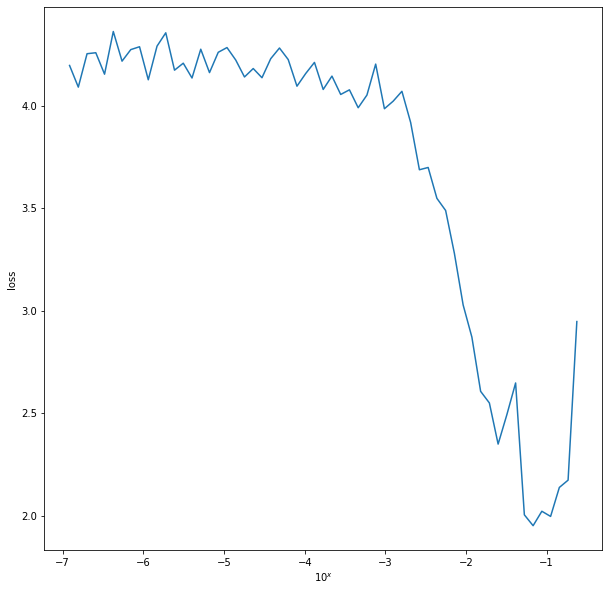

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")

In [ ]:
10**(-1.15)

0.0707945784384138

In [ ]:
opt = torch.optim.Adam(model_final_ensemble.classifier.parameters(), lr=0.07, amsgrad=True)


In [ ]:
name = '/content/gdrive/MyDrive/DogsModel_finalENSEMBLE.pth'
torch.cuda.empty_cache()
history = train(train_dataset, val_dataset, model = model_final_ensemble.cuda(), opt = opt, epochs = 10, batch_size = 32, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.001109192439691


epoch:  10%|█         | 1/10 [04:40<42:00, 280.10s/it]

Saved model with val acc 0.7444196428571428

Epoch 001 train_loss: 3.0011   val_loss 0.8500 train_acc 0.2426 val_acc 0.7444
loss 0.42547682360241657


epoch:  20%|██        | 2/10 [09:13<37:04, 278.10s/it]

Saved model with val acc 0.8917410714285714

Epoch 002 train_loss: 0.4255   val_loss 0.3478 train_acc 0.8683 val_acc 0.8917
loss 0.32195771787527727


epoch:  30%|███       | 3/10 [13:46<32:16, 276.66s/it]

Saved model with val acc 0.91796875

Epoch 003 train_loss: 0.3220   val_loss 0.2489 train_acc 0.9029 val_acc 0.9180
loss 0.2890685709116403


epoch:  40%|████      | 4/10 [18:19<27:33, 275.57s/it]

Saved model with val acc 0.9241071428571428

Epoch 004 train_loss: 0.2891   val_loss 0.2552 train_acc 0.9137 val_acc 0.9241
loss 0.29252571254624815


epoch:  50%|█████     | 5/10 [22:53<22:54, 274.85s/it]

Saved model with val acc 0.9408482142857142

Epoch 005 train_loss: 0.2925   val_loss 0.2124 train_acc 0.9129 val_acc 0.9408
loss 0.2511704595760204


epoch:  60%|██████    | 6/10 [27:20<18:10, 272.73s/it]


Epoch 006 train_loss: 0.2512   val_loss 0.3799 train_acc 0.9228 val_acc 0.8945
loss 0.24995394681060806


epoch:  70%|███████   | 7/10 [31:48<13:33, 271.19s/it]


Epoch 007 train_loss: 0.2500   val_loss 0.2324 train_acc 0.9272 val_acc 0.9314
loss 0.2234636491443927


epoch:  80%|████████  | 8/10 [36:21<09:03, 271.77s/it]

Saved model with val acc 0.9453125

Epoch 008 train_loss: 0.2235   val_loss 0.2036 train_acc 0.9401 val_acc 0.9453
loss 0.2125037451703441


epoch:  90%|█████████ | 9/10 [40:49<04:30, 270.52s/it]


Epoch 009 train_loss: 0.2125   val_loss 0.2056 train_acc 0.9388 val_acc 0.9436
loss 0.20461848256731727


epoch: 100%|██████████| 10/10 [45:22<00:00, 272.26s/it]

Saved model with val acc 0.9486607142857142

Epoch 010 train_loss: 0.2046   val_loss 0.1935 train_acc 0.9401 val_acc 0.9487


In [ ]:
checkpoint = torch.load(name)
model_final_ensemble.load_state_dict(checkpoint['model_state_dict'])

model_final_ensemble.eval()
probs_ims = predict(model_final_ensemble, imgs)
actual_labels = [val_dataset[id][1] for id in idxs]
from sklearn.metrics import f1_score
f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro')

0.9534264803725881

#Ансамбль из всех сетей без поиска lr

In [ ]:
model_vgg = models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=50, bias=True)
checkpoint = torch.load('/content/gdrive/MyDrive/DogsModelVGG_with_LR.pth')
model_vgg.load_state_dict(checkpoint['model_state_dict'])

model_densenet = models.densenet161(pretrained=True)
model_densenet.classifier = nn.Sequential(nn.Linear(2208, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(128, 50))
checkpoint = torch.load('/content/gdrive/MyDrive/DogsModelDENSENET161_with_LR.pth')
model_densenet.load_state_dict(checkpoint['model_state_dict'])

model_resnet = models.resnet152(pretrained=True)
model_resnet = model_resnet.cuda()
model_resnet.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=1000, bias=True),
 nn.Dropout(0.5),
 nn.Linear(1000, 50, bias=True))
checkpoint = torch.load('/content/gdrive/MyDrive/DogsModelRESNET152_with_LR.pth')
model_resnet.load_state_dict(checkpoint['model_state_dict'])

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model_effnet_b6 = EfficientNet.from_pretrained('efficientnet-b6', num_classes=50)
model_effnet_b6 = model_effnet_b6.cuda()
checkpoint = torch.load('/content/gdrive/MyDrive/DogsModelEFFNET_B6_with_LR.pth')
model_effnet_b6.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
model_final_ensemble = MyEnsemble(model_vgg,
                            model_densenet,
                            model_resnet,
                            model_effnet_b6)


In [ ]:
for param in model_final_ensemble.parameters():
    param.requires_grad = False
for param in model_final_ensemble.classifier.parameters():
    param.requires_grad = True

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

opt = torch.optim.Adam(model_final_ensemble.classifier.parameters(), lr=0.003, amsgrad=True)

In [ ]:
name = '/content/gdrive/MyDrive/DogsModel_finalENSEMBLE_003.pth'
torch.cuda.empty_cache()
history = train(train_dataset, val_dataset, model = model_final_ensemble.cuda(), opt = opt, epochs = 10, batch_size = 32, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.8404801217960434


epoch:  10%|█         | 1/10 [04:26<40:02, 266.93s/it]

Saved model with val acc 0.9469866071428571

Epoch 001 train_loss: 1.8405   val_loss 0.3866 train_acc 0.5158 val_acc 0.9470
loss 0.21899836393683916


epoch:  20%|██        | 2/10 [08:58<35:45, 268.19s/it]

Saved model with val acc 0.9609375

Epoch 002 train_loss: 0.2190   val_loss 0.1465 train_acc 0.9427 val_acc 0.9609
loss 0.16673068270214791


epoch:  30%|███       | 3/10 [13:26<31:17, 268.21s/it]


Epoch 003 train_loss: 0.1667   val_loss 0.1559 train_acc 0.9505 val_acc 0.9565
loss 0.13701767639950566


epoch:  40%|████      | 4/10 [17:59<26:59, 269.84s/it]

Saved model with val acc 0.9631696428571428

Epoch 004 train_loss: 0.1370   val_loss 0.1315 train_acc 0.9587 val_acc 0.9632
loss 0.12409994655968444


epoch:  50%|█████     | 5/10 [22:33<22:35, 271.08s/it]

Saved model with val acc 0.9637276785714285

Epoch 005 train_loss: 0.1241   val_loss 0.1249 train_acc 0.9607 val_acc 0.9637
loss 0.1184001973520647


epoch:  60%|██████    | 6/10 [27:07<18:07, 271.82s/it]

Saved model with val acc 0.9670758928571428

Epoch 006 train_loss: 0.1184   val_loss 0.1210 train_acc 0.9617 val_acc 0.9671
loss 0.11427458325781518


epoch:  70%|███████   | 7/10 [31:36<13:32, 270.83s/it]


Epoch 007 train_loss: 0.1143   val_loss 0.1164 train_acc 0.9628 val_acc 0.9671
loss 0.11055066439163343


epoch:  80%|████████  | 8/10 [36:04<09:00, 270.04s/it]


Epoch 008 train_loss: 0.1106   val_loss 0.1343 train_acc 0.9646 val_acc 0.9632
loss 0.08067615808392929


epoch:  90%|█████████ | 9/10 [40:38<04:31, 271.26s/it]

Saved model with val acc 0.9693080357142857

Epoch 009 train_loss: 0.0807   val_loss 0.1217 train_acc 0.9743 val_acc 0.9693
loss 0.0881546224565545


epoch: 100%|██████████| 10/10 [45:07<00:00, 270.74s/it]


Epoch 010 train_loss: 0.0882   val_loss 0.1246 train_acc 0.9725 val_acc 0.9660


In [ ]:
checkpoint = torch.load(name)
model_final_ensemble.load_state_dict(checkpoint['model_state_dict'])

model_final_ensemble.eval()
probs_ims = predict(model_final_ensemble, imgs)
actual_labels = [val_dataset[id][1] for id in idxs]
from sklearn.metrics import f1_score
f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro')

0.9720558882235529

Лучший скор на тесте - 97,2% - получен путем ансамблирования стеккингом 4 сетей - DenseNet, ResNet, VGG, EfficientNet - b6.

#Сокращаем датасет и протестируем  лучшую модель, но обученную с 0

В этой ячейке загружаются модели, ансамбль которых дал наилучший скор

In [32]:
model_vgg = models.vgg19(pretrained=True)
model_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=50, bias=True)

model_densenet = models.densenet161(pretrained=True)
model_densenet.classifier = nn.Sequential(nn.Linear(2208, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(128, 50))

model_resnet = models.resnet152(pretrained=True)
model_resnet.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=1000, bias=True),
 nn.Dropout(0.5),
 nn.Linear(1000, 50, bias=True))

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model_effnet_b6 = EfficientNet.from_pretrained('efficientnet-b6', num_classes=50)

Loaded pretrained weights for efficientnet-b6


Объединяем в ансамбль

In [33]:
model_final_ensemble = MyEnsemble(model_vgg,
                            model_densenet,
                            model_resnet,
                            model_effnet_b6)


Размораживаем веса, поскольку нам надо обучить модель с нуля

In [34]:
for param in model_final_ensemble.parameters():
    param.requires_grad = True

Здесь несколько раз разделяем тестовую выборку, чтобы ее сократить

In [37]:
train_labels = [path.parent.name for path in train_files]
train1, train2 = train_test_split(train_files, test_size=0.1, \
 stratify=train_labels)

train2_labels = [path.parent.name for path in train2]
train2, val2 = train_test_split(train2, test_size=0.2, \
 stratify=train2_labels)

In [38]:
train2 = DogsDataset(train2, mode='train')
val2 = DogsDataset(val2, mode='val')

Количество изображений в каждом классе в трейне

In [39]:
d = dict()
for i in range(50):
  d[i] = 0

for i, j in train2:
  d[j]+=1
d

{0: 9,
 1: 8,
 2: 8,
 3: 8,
 4: 7,
 5: 8,
 6: 10,
 7: 9,
 8: 10,
 9: 9,
 10: 8,
 11: 10,
 12: 8,
 13: 9,
 14: 8,
 15: 8,
 16: 7,
 17: 8,
 18: 15,
 19: 9,
 20: 7,
 21: 7,
 22: 7,
 23: 7,
 24: 10,
 25: 7,
 26: 7,
 27: 7,
 28: 7,
 29: 12,
 30: 10,
 31: 12,
 32: 11,
 33: 10,
 34: 9,
 35: 11,
 36: 8,
 37: 7,
 38: 10,
 39: 7,
 40: 8,
 41: 10,
 42: 8,
 43: 7,
 44: 8,
 45: 8,
 46: 7,
 47: 8,
 48: 10,
 49: 7}

Количество изображений в каждом классе в валидационной выборке

In [40]:
d = dict()
for i in range(50):
  d[i] = 0

for i, j in val2:
  d[j]+=1
d

{0: 2,
 1: 2,
 2: 2,
 3: 2,
 4: 2,
 5: 2,
 6: 2,
 7: 2,
 8: 3,
 9: 2,
 10: 2,
 11: 2,
 12: 2,
 13: 2,
 14: 2,
 15: 2,
 16: 2,
 17: 2,
 18: 4,
 19: 2,
 20: 2,
 21: 2,
 22: 2,
 23: 2,
 24: 2,
 25: 2,
 26: 2,
 27: 2,
 28: 2,
 29: 3,
 30: 3,
 31: 3,
 32: 2,
 33: 3,
 34: 2,
 35: 2,
 36: 2,
 37: 2,
 38: 2,
 39: 2,
 40: 2,
 41: 2,
 42: 2,
 43: 2,
 44: 2,
 45: 2,
 46: 2,
 47: 2,
 48: 3,
 49: 2}

Обучение с теми же параметрами, на которых ансамбль дал наилучший скор

In [41]:
name = '/content/gdrive/MyDrive/DogsModel_shortFinalENSEMBLE_003.pth'
torch.cuda.empty_cache()
loss_fn = nn.CrossEntropyLoss()

opt = torch.optim.Adam(model_final_ensemble.classifier.parameters(), lr=0.003, amsgrad=True)

history = train(train_files = train2, val_files = val2, model = model_final_ensemble.cuda(), opt = opt, epochs = 10, batch_size = 8, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 4.207388752560282


epoch:  10%|█         | 1/10 [00:43<06:29, 43.33s/it]

Saved model with val acc 0.14814814814814814

Epoch 001 train_loss: 4.2074   val_loss 3.4968 train_acc 0.0279 val_acc 0.1481
loss 2.7806508585464123


epoch:  20%|██        | 2/10 [01:25<05:43, 42.88s/it]

Saved model with val acc 0.5555555555555556

Epoch 002 train_loss: 2.7807   val_loss 1.9264 train_acc 0.3744 val_acc 0.5556
loss 1.1564278674680133


epoch:  30%|███       | 3/10 [02:07<04:59, 42.73s/it]

Saved model with val acc 0.6944444444444444

Epoch 003 train_loss: 1.1564   val_loss 1.0817 train_acc 0.7721 val_acc 0.6944
loss 0.4156286703985791


epoch:  40%|████      | 4/10 [02:49<04:14, 42.45s/it]

Saved model with val acc 0.7592592592592592

Epoch 004 train_loss: 0.4156   val_loss 0.8441 train_acc 0.9186 val_acc 0.7593
loss 0.24834779577199803


epoch:  50%|█████     | 5/10 [03:26<03:23, 40.80s/it]


Epoch 005 train_loss: 0.2483   val_loss 0.8472 train_acc 0.9558 val_acc 0.7407
loss 0.16609281637640885


epoch:  60%|██████    | 6/10 [04:08<02:44, 41.07s/it]

Saved model with val acc 0.7685185185185185

Epoch 006 train_loss: 0.1661   val_loss 0.7060 train_acc 0.9628 val_acc 0.7685
loss 0.15404380395315415


epoch:  70%|███████   | 7/10 [04:45<01:59, 39.88s/it]


Epoch 007 train_loss: 0.1540   val_loss 0.7521 train_acc 0.9767 val_acc 0.7593
loss 0.11196330392429996


epoch:  80%|████████  | 8/10 [05:27<01:21, 40.64s/it]

Saved model with val acc 0.787037037037037

Epoch 008 train_loss: 0.1120   val_loss 0.7670 train_acc 0.9767 val_acc 0.7870
loss 0.04778576866658621


epoch:  90%|█████████ | 9/10 [06:04<00:39, 39.54s/it]


Epoch 009 train_loss: 0.0478   val_loss 0.7352 train_acc 0.9930 val_acc 0.7870
loss 0.1249416901794977


epoch: 100%|██████████| 10/10 [06:41<00:00, 40.12s/it]


Epoch 010 train_loss: 0.1249   val_loss 0.8546 train_acc 0.9698 val_acc 0.7685


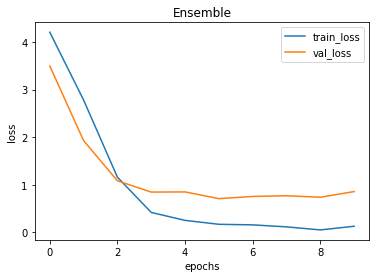

In [46]:
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Ensemble")
plt.show()

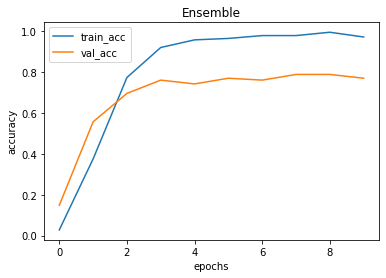

In [47]:
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Ensemble")
plt.show()

Проверяем __на всей__ валидационной выборке (той, что выделяется в начале ноутбука, большого размера)

In [48]:
name = '/content/gdrive/MyDrive/DogsModel_shortFinalENSEMBLE_003.pth'
checkpoint = torch.load(name)
model_final_ensemble.load_state_dict(checkpoint['model_state_dict'])
model_final_ensemble.eval()

probs_ims = predict(model_final_ensemble.cuda(), imgs)
actual_labels = [val_dataset[id][1] for id in idxs]

from sklearn.metrics import f1_score
f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro')

0.828125